<a href="https://colab.research.google.com/github/wolfinwallst/Machine_Learning_Deep_basis/blob/main/RNN_on_predicting_stock_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

reference: [blog](https://data-science-hi.tistory.com/190)

our objective: is to get used to implementing & applying `vanilla RNN` on a time series data, which is `many-to-one` type.

여기에선 431일치 종가 데이터를 입력받고, MinMaxScaler로 전처리하고,
sliding window of size 5 로 한 칸씩 이동하면서 x_seq, y_seq를 만든다.

이를 다시 앞 split(=200)개/뒤 226개로 각각 x_train_seq, x_test_seq으로,
y_train_seq, y_test_seq으로 나눈다.

이를 batch_size(=20) 크기의 배치들로 나눈다. (각 10, 12 배치)

이제 VanillaRNN 을 정의하고, num_epochs(=200) 에포크만큼 나눈 배치들로  
RNN 학습을 진행한다.



In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
df = pd.read_csv('/content/gdrive/MyDrive/data/kospi.csv')

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,2183.489990,2206.199951,2177.879883,2206.199951,2206.199951,480400
1,2019-01-31,2222.879883,2222.879883,2201.219971,2204.850098,2204.850098,545200
2,2019-02-01,2211.929932,2218.780029,2201.409912,2203.459961,2203.459961,479400
3,2019-02-07,2215.770020,2215.790039,2196.770020,2203.419922,2203.419922,427800
4,2019-02-08,2192.010010,2192.479980,2171.959961,2177.050049,2177.050049,391000


In [3]:
# Date 변수를 제외하고 최대최소 정규화
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(
    df[['Open', 'High', 'Low', 'Close', 'Volume']])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       431 non-null    object 
 1   Open       431 non-null    float64
 2   High       431 non-null    float64
 3   Low        431 non-null    float64
 4   Close      431 non-null    float64
 5   Adj Close  431 non-null    float64
 6   Volume     431 non-null    float64
dtypes: float64(6), object(1)
memory usage: 23.7+ KB


In [5]:
# GPU 활성화 여부 점검
device = torch.device('cude:0' if torch.cuda.is_available() else 'cpu')
print(f' {device} is available')

 cpu is available


In [6]:
# 데이터 셋을 target 기준으로 분리
X = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

In [7]:
print(len(X), len(y))

431 431


In [8]:
"""
시계열 데이터(X, y)에서 sequence_length 길이(아래에서 5로 설정)만큼 split하는 함수
"""
def seq_data(x, y, sequence_length):
    x_seq = []
    y_seq = []

    for i in range(len(x) - sequence_length): # i=0부터 431-5=426까지
        x_seq.append(x[i:i + sequence_length])
        y_seq.append(y[i + sequence_length])

    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1])

In [9]:
split = 200 # 데이터의 개수로, 앞쪽은 training에, 뒷쪽은 test 데이터로 사용
sequence_length = 5

x_seq, y_seq = seq_data(X, y, sequence_length)

print(len(x_seq), len(y_seq))
print(x_seq.size(), y_seq.size(), '\n')

# train/test 데이터 셋으로 앞 200개/ 뒤 나머지(226개)로 나누자
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

426 426
torch.Size([426, 5, 4]) torch.Size([426, 1]) 

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([226, 5, 4]) torch.Size([226, 1])


<ipython-input-8-0e8279ffcab0>:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1])


In [10]:
"""
이걸 보면 슬라이딩 윈도우(사이즈 5)로 나뉜 걸 확인할 수 있다.
"""
print(x_seq[0], x_seq[1])

tensor([[0.7229, 0.7324, 0.7455, 0.2421],
        [0.7631, 0.7501, 0.7691, 0.2748],
        [0.7519, 0.7457, 0.7693, 0.2416],
        [0.7558, 0.7425, 0.7646, 0.2156],
        [0.7316, 0.7178, 0.7395, 0.1971]]) tensor([[0.7631, 0.7501, 0.7691, 0.2748],
        [0.7519, 0.7457, 0.7693, 0.2416],
        [0.7558, 0.7425, 0.7646, 0.2156],
        [0.7316, 0.7178, 0.7395, 0.1971],
        [0.7199, 0.7062, 0.7349, 0.2047]])


In [11]:
"""
(TensorDataset)으로 입력과 정답 텐서를 하나의 데이터셋으로 묶어
각 인덱스마다 (x, y) 튜플을 제공한다.
시계열 데이터의 순서를 그대로 유지하며, 전체 샘플 수를 파악할 수 있다.

x_train_seq, y_train_seq (또는 x_test_seq, y_test_seq)는
각각 입력 데이터와 정답(라벨) 데이터를 담고 있는 텐서이다.

TensorDataset은 두 개 이상의 텐서를 받아, 동일한 첫 번째 차원(샘플 개수)을 가지는 경우
각 인덱스에 대해 튜플 (x, y) 형태의 데이터를 생성한다.
예를 들어, x_train_seq[i]와 y_train_seq[i]를 묶어 하나의 학습 샘플로 사용한다.

시계열 데이터에서는 순서가 중요한 만큼, 원본 데이터의 순서를 그대로 유지하면서
각 시점의 데이터를 입력과 정답으로 묶어 다루게 된다.
"""
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

print(len(train), len(test)) # 데이터셋에 포함된 샘플의 총 개수

"""
(DataLoader)로 TensorDataset을 기반으로
지정된 배치 크기로 데이터를 묶어 순차적으로 제공한다.

DataLoader는 이터레이터(iterator)로 동작하여 for-loop 등을 통해 배치 단위로 데이터를
순회할 수 있게 한다. batch 형태로 만들기_시계열이므로 무작위 셔플을 하면 안 된다.
즉, 시계열 데이터의 순서를 보존하기 위해 shuffle=False 옵션을 사용한다.

반복문에서 배치 단위로 데이터를 읽어 학습 및 평가에 활용할 수 있다.
"""
batch_size = 20 # DataLoader는 데이터셋을 batch_size(=20)개씩 묶어서 배치(batch)를 생성
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

# 배치 개수 (각 10, 12개): 각각 데이터셋이 몇 개의 배치로 나누어지는지를 나타냄
print(len(train_loader), len(test_loader))

200 226
10 12


In [12]:
print(train_loader, test_loader)

<torch.utils.data.dataloader.DataLoader object at 0x7e812bb0a910> <torch.utils.data.dataloader.DataLoader object at 0x7e812be4f410>


In [13]:
"""
입력노드 수, 레이어의 개수, hidden state의 크기
layer나 hidden state를 더 많이 받는다는 것은 정보를 받는 가용성이 더 커지는 것이기
때문에 너무 크게 늘리면 오버피팅될 가능성이 있다.

[hyperparameters]
"""
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [14]:
x_seq.size()

torch.Size([426, 5, 4])

In [15]:
"""
many-to-one 바닐라 RNN 모델 구축
"""
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(VanillaRNN, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) # many-to-one RNN

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state 설정
        out, _ = self.rnn(x, h0) # out: RNN의 마지막 레이어로부터 나온 output feature를 반환 / hn: hidden state를 반환
        out = out.reshape(out.shape[0], -1) # many-to-one 구조
        out = self.fc(out)
        return out

model = VanillaRNN(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [16]:
criterion = nn.MSELoss() # regression 문제

lr = 1e-3
num_epochs = 200
optimizer = optim.Adam(model.parameters(), lr=lr)

In [17]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:
        seq, target = data # batch 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() # 현재 batch에서 계산된 loss를 합산

    loss_graph.append(running_loss / n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f'%(epoch, running_loss / n))

[epoch: 0] loss: 0.0309
[epoch: 10] loss: 0.0063
[epoch: 20] loss: 0.0059
[epoch: 30] loss: 0.0053
[epoch: 40] loss: 0.0042
[epoch: 50] loss: 0.0025
[epoch: 60] loss: 0.0011
[epoch: 70] loss: 0.0009
[epoch: 80] loss: 0.0008
[epoch: 90] loss: 0.0008
[epoch: 100] loss: 0.0008
[epoch: 110] loss: 0.0008
[epoch: 120] loss: 0.0008
[epoch: 130] loss: 0.0008
[epoch: 140] loss: 0.0007
[epoch: 150] loss: 0.0007
[epoch: 160] loss: 0.0007
[epoch: 170] loss: 0.0007
[epoch: 180] loss: 0.0007
[epoch: 190] loss: 0.0007


In [18]:
print(n) # train_loader 배치 개수

10


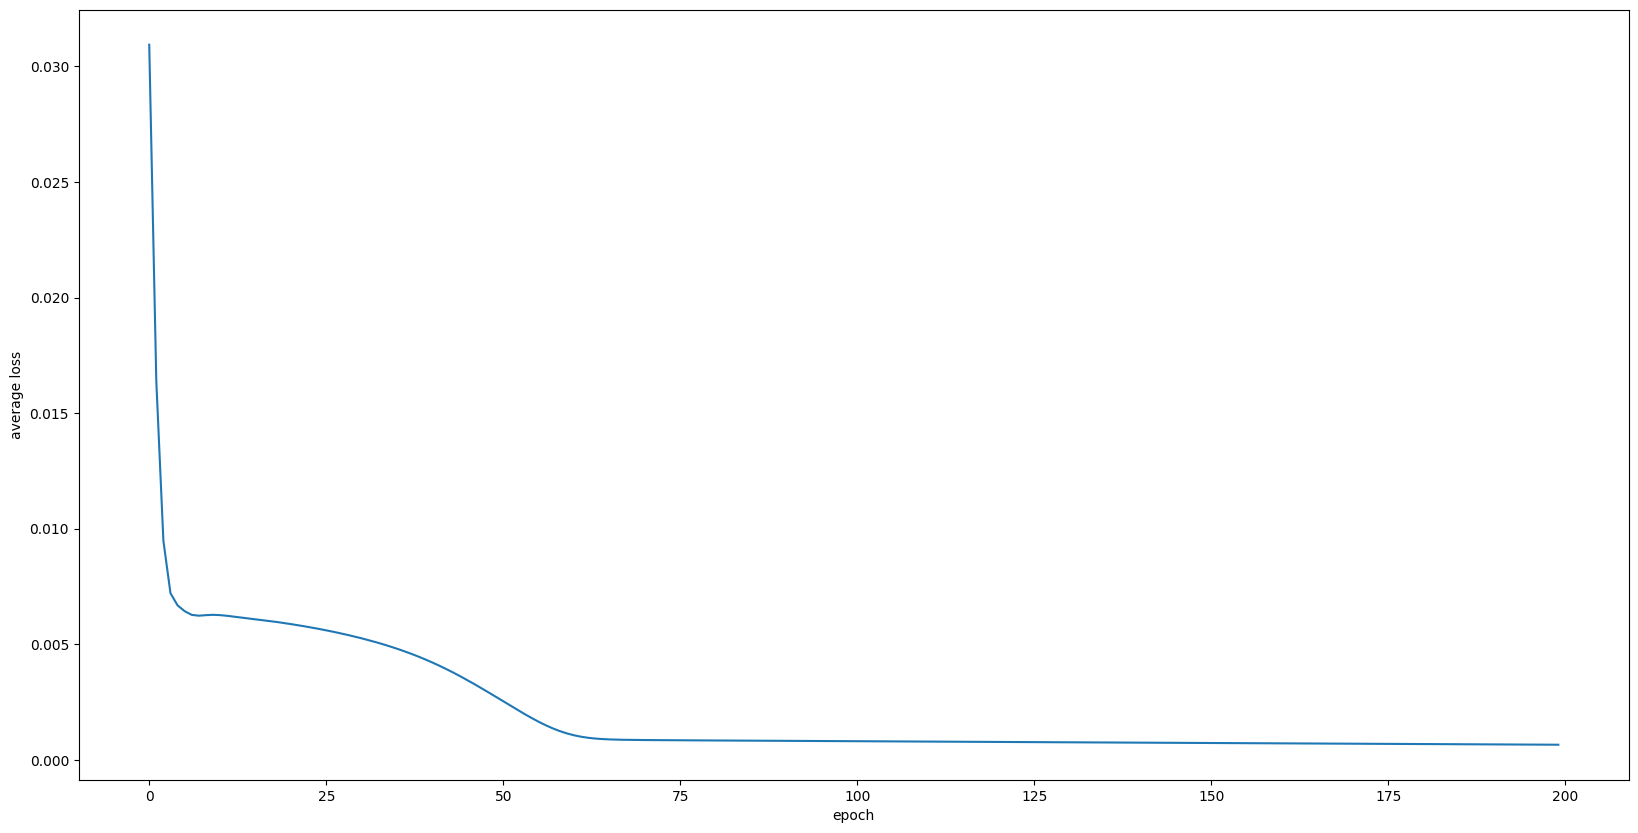

In [19]:
"""
loss 그래프 - SGD based optimizer 를 사용하는 지도 학습이다.
"""
plt.figure(figsize=(20, 10))
plt.xlabel('epoch')
plt.ylabel('average loss')
plt.plot(loss_graph)
plt.show()

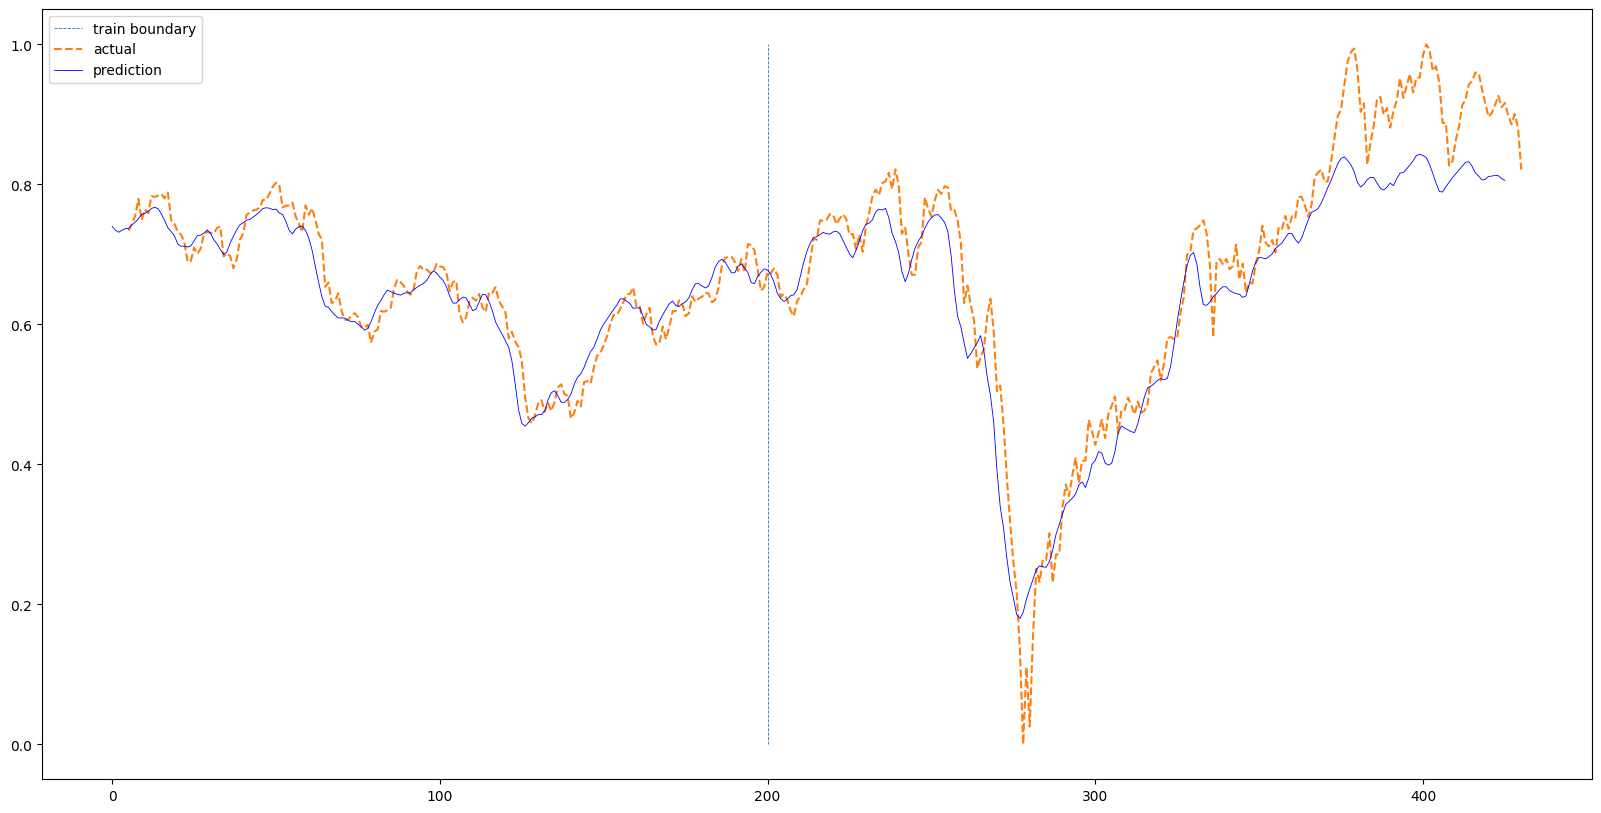

In [20]:
"""
actual Close vs predicted values 를 그려보자
"""
def plotting(train_loader, test_loader, actual):
   with torch.no_grad():
    train_pred = []
    test_pred = []

    for data in train_loader:
      seq, target = data
      out = model(seq)
      train_pred += out.cpu().numpy().tolist()

    for data in test_loader:
      seq, target = data
      out = model(seq)
      test_pred += out.cpu().numpy().tolist()

   total = train_pred + test_pred # pred

   plt.figure(figsize=(20, 10))
   plt.plot(np.ones(100)*len(train_pred), np.linspace(0, 1, 100), '--', linewidth=0.6) # train boundary
   plt.plot(actual, '--')
   plt.plot(total, 'b', linewidth=0.6) # prediction
   plt.legend(['train boundary', 'actual', 'prediction'])
   plt.show()

plotting(train_loader, test_loader, df['Close'][sequence_length:])



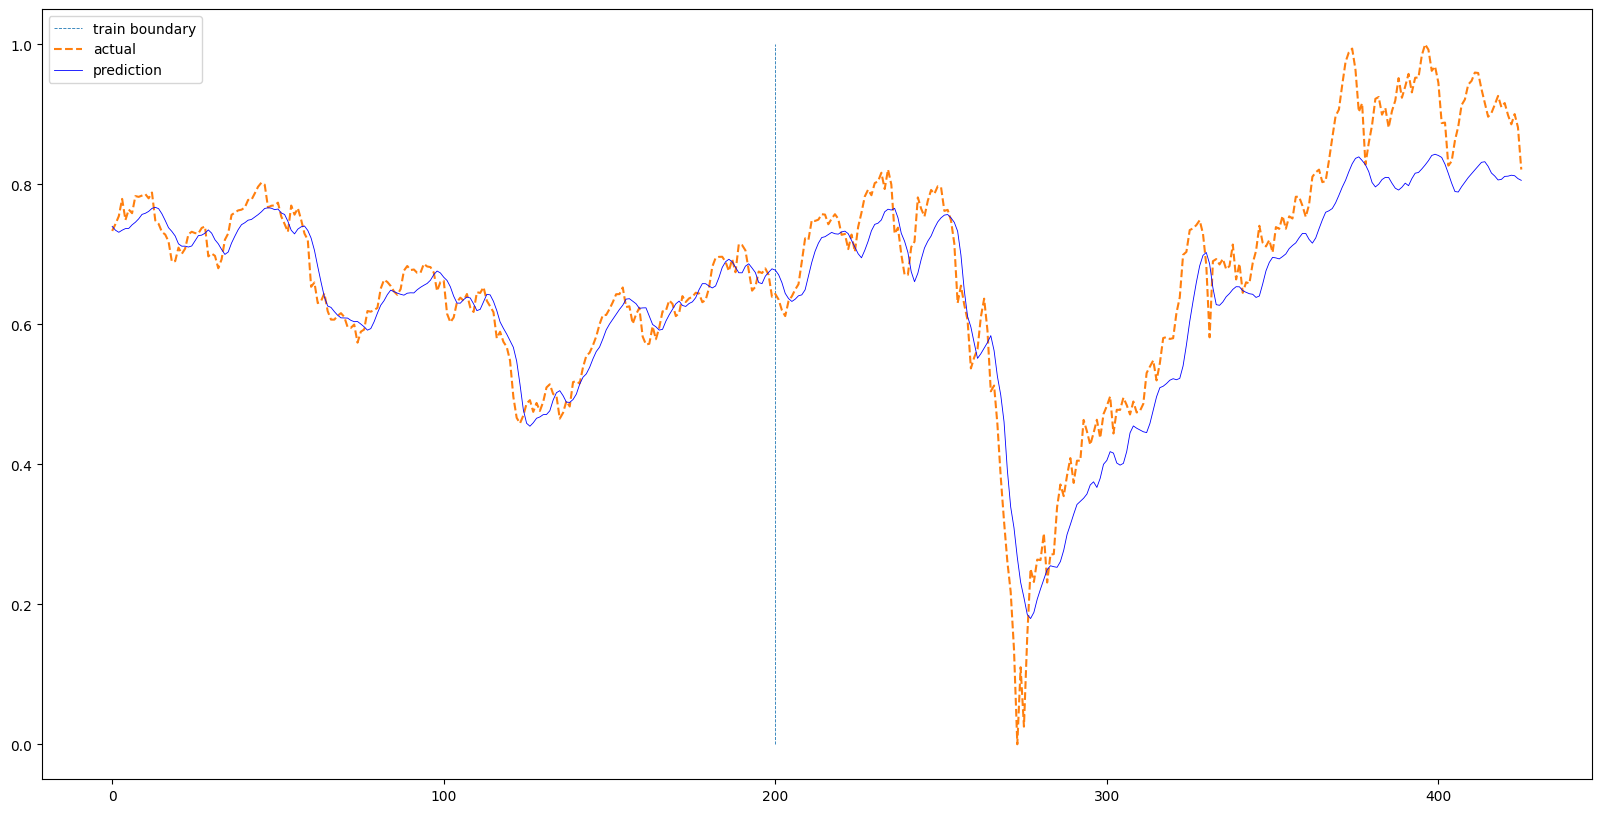

In [21]:
"""
위 셀 마지막 코드 ( df['Close'][sequence_length:] )와 실제 그래프를 보면
actual 그래프가 index 5부터 그려졌음을 알 수 있다. 이를 수정하려면,

actual 뒤에 .values를 붙이면 된다.
"""
plotting(train_loader, test_loader, df['Close'][sequence_length:].values)